In [1]:
import numpy as np
import matplotlib.pyplot as plt
import fastpt.HT as HT
import models as md
import fastpt as fpt
import cosmoprimo

Om0 = 0.319
Omb = 0.049
Omc = Om0 - Omb
mnu = 0.
As = 2.1e-9
ns = 0.96
h = 0.67
zeff = 0.7
z_start = 0.2
cosmo_list = [Omc,Omb,mnu,As,ns,h,zeff]
rpt = np.geomspace(1e-1,100,400)

In [70]:
""" PK estimation """


class cosmo:

    """set params for cosmoprimo"""
    def __init__(self,h,Omc,Omb,A_s,s8,n_s,Omega_ncdm,kmax):
        if A_s is None:
            self.cosmop = cosmoprimo.Cosmology(h=h,Omega_c=Omc,Omega_b=Omb,sigma8=s8,n_s=n_s,Omega_ncdm=Omega_ncdm,engine="class",non_linear='mead',kmax_pk=kmax)
        else :
            self.cosmop = cosmoprimo.Cosmology(h=h,Omega_c=Omc,Omega_b=Omb,A_s=A_s,n_s=n_s,Omega_ncdm=Omega_ncdm,engine="class",non_linear='mead',kmax_pk=kmax)

        fourier = cosmoprimo.Fourier(self.cosmop,engine="class")
        self.pk_lin_2D = fourier.pk_interpolator(extrap_kmin=1e-5)
        self.pk_nl_2D = fourier.pk_interpolator(extrap_kmin=1e-5,non_linear=True)

    def set_redshift(self,z):
        self.zeq = z
        self.sigma8_z = self.cosmop.sigma8_z(self.zeq)
        self.sigmav_z = self.pk_lin_2D.sigma_dz(self.zeq)
        self.RHO_M = self.cosmop.rho_m(self.zeq)*1e10
        self.gz = self.cosmop.growth_factor(z)
        

        
cosmop = cosmo(h=h,Omc=Omc,Omb=Omb,A_s=As,s8=None,n_s=ns,Omega_ncdm=0,kmax=100)
k=np.logspace(-5,2,1024)
cosmop.set_redshift(zeff)
pklin = cosmop.pk_lin_2D(k,z=zeff)
pknl = cosmop.pk_nl_2D(k,z=zeff)

In [72]:
""" Current pyccl implementation """

b1 = 2.
A1 = 2.
A2 = 3.
bTA = 2.


pyccl_model = md.twopt_model(cosmo_list,'TATT',computation=['WGG','WGP'])
params =[b1,0.,0.,0.,A1,A2,bTA]
pyccl_model.set_pks2D(params)

p_gI = pyccl_model.h**3*pyccl_model.pk_gi.eval(pyccl_model.ks,1./(1+pyccl_model.zeff),pyccl_model.cosmo)


In [73]:

""" FAST-PT call"""

to_do = ['IA_all']

pad_factor = 1 
n_pad = pad_factor*len(k)
low_extrap = -5
high_extrap = 2 
P_window = None 
C_window = .75 

pt = fpt.FASTPT(k, to_do=to_do,
                             low_extrap=low_extrap,
                             high_extrap=high_extrap,
                             n_pad=n_pad)

""" can replace by pklin0 and multiply by g**4, like in pyccl"""
ia_ta = pt.IA_ta(P=pklin)
ia_mix = pt.IA_mix(P=pklin)
ia_tij = pt.IA_tij(P=pklin)
ia_gb2 = pt.IA_gb2(P=pklin)         
ia_s2 = pt.IA_s2(P=pklin)         

a00e, c00e, a0e0e, a0b0b = ia_ta
a0e2, b0e2, d0ee2, d0bb2 = ia_mix
t1,t2,t3,t4= ia_tij
gb1,gb2,gb3,gb4 = ia_gb2
s21,s22,s23,s24 = ia_s2
btij = 2.

""" This is how i define A1d in the pyccl script"""
A1d = A1*bTA

C1 = -A1*cosmop.RHO_M*5e-14/cosmop.gz
Cd = -A1d*5e-14*cosmop.RHO_M/cosmop.gz
C2 = A2*5*5e-14*cosmop.RHO_M/(cosmop.gz**2)
Ctij = -btij*cosmop.RHO_M*5e-14/cosmop.gz



In [74]:
bs2 = -4./7.*(b1 - 1.)
b2 = -0.1
pgi_lin = b1 * (C1* pknl  + Cd *(a00e + c00e) + C2*(a0e2 + b0e2) + Ctij*(t1 + t2))


Text(0, 0.5, '$P_{gI}$')

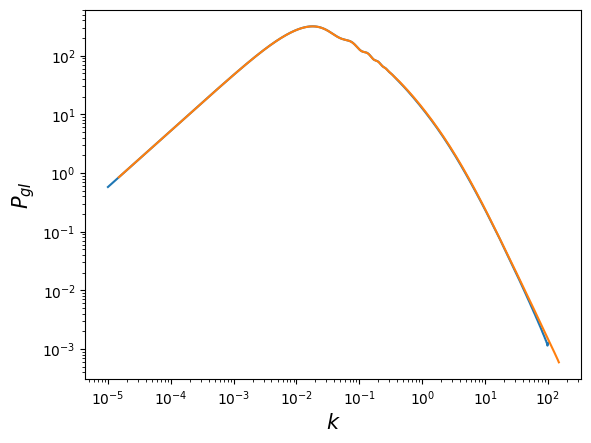

In [82]:
"""Comparaison between pyccl and this implementation, it is the same"""

plt.loglog(k,-pgi_lin)
plt.loglog(pyccl_model.k,-p_gI)
plt.xlabel(r'$k$',fontsize=15)
plt.ylabel(r'$P_{gI}$',fontsize=15)

# plt.loglog(k,-pgi)

In [84]:
""" New p_gI, probably wrong
Should i include the C terms in the expansion ?
Should i include all tij terms, all gb2 terms, and all s2 terms? For example, for IA_mix and IA_ta, only the first two terms are kept"""

pgi = b1 * (C1* pknl  + Cd *(a00e + c00e) + C2*(a0e2 + b0e2) + Ctij*(t1 + t2)) + b2/2.*(Cd*gb1 + C2*gb2) + bs2/2.*(Cd*s21 + C2*s22)